In [ ]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-5-nano-2025-08-07",
               temperature=0)


In [ ]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary : str

In [ ]:
from langchain_core.messages import SystemMessage 
# nood to call llm with summary

def call_model(state : State):
    
    summary=state.get("summary", "")
    
    if summary: # si summary rajoute aux messages 
        system_message=f"Summary of conversation earlier: {summary}"
        
        messages= [SystemMessage(content=system_message)] + state['messages']
    
    else : # sinon garder les messages 
        messages = state['messages']
    
    # envoi 
    response=llm.invoke(messages)
    return {"messages":response }

In [15]:
print(State.__annotations__)

{'messages': ForwardRef('Annotated[list[AnyMessage], add_messages]', module='langgraph.graph.message'), 'summary': <class 'str'>}


In [24]:
from langchain_core.messages import HumanMessage, RemoveMessage
def summerize_conversation(state:State):
    
    summary=state.get("summary","")
    
    # cas 1 : il existe donc on le récupère
    if summary: 
        summary_message=(
            f"this is the summary of the conv  : {summary}"
        )
    # cas 2: il n existe pas donc on le cree
    else: 
        summary_message="Create the summary of the conversation above"
        
    # add summary to our history
    all_messages= state['messages']+ [HumanMessage(content=summary_message)]
    reponse=llm.invoke(all_messages)
    
    # delete all but not 2 last
    deleted_messages=[RemoveMessage(id=m.id) for m in state["messages"][:2]]
    
    return {"summary": reponse.content, "messages": deleted_messages}
    
    

In [27]:
from typing_extensions import Literal
from langgraph.graph import END 

def should_continue(state : State) -> Literal["summerize_conversation", END]:
    messages=state["messages"]
    # if more than 6 messages résume
    if len(messages)>6 :
        return "summerize_conversation"
    
    return END 

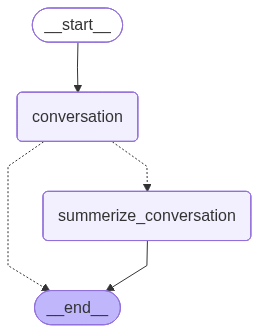

In [35]:
from IPython.display import Image , display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph , START

workflow=StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summerize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summerize_conversation", END )

memory=MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
# threads
config={"configurable":{"thread_id":"1"}}

# start conv
input_message=HumanMessage(content="Hi ! I m ouss kouss")
output=graph.invoke({"messages":[input_message]}, config )

input_message=HumanMessage(content="what is my name ?")
output=graph.invoke({"messages": [input_message]}, config)

input_message=HumanMessage(content="i like coding and AI, feel that i have found my path with my AI Engineer new position")
output=graph.invoke({"messages": [input_message]}, config)

In [59]:
from pprint import pprint, PrettyPrinter

for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi ! I m ouss kouss
================================== Ai Message ==================================

Hi Ouss Kouss! Nice to meet you.

What would you like to do today? Here are a few quick ideas:
- Explain a concept or answer a question
- Help with writing, editing, or drafting
- Solve a math problem or a coding task
- Practice a language (English, French, Arabic, etc.)
- Brainstorm ideas for a project or study plan
- Translate something or write a short message
- Play a quick word game

Would you like to chat in English, or switch to French, Arabic, or another language? Tell me what you’d like to do.
================================ Human Message =================================

what is my name ?
================================== Ai Message ==================================

From what you told me, your name is Ouss Kouss. Do you prefer to be called Ouss, Kouss, or a different nickname? How would you

In [61]:
summary=graph.get_state(config).values.get("summary","")

In [63]:
pprint(summary)

('Summary of the conversation:\n'
 '\n'
 '- The user introduced themselves as Ouss Kouss and the assistant confirmed '
 'the name, asking how they’d like to be addressed.\n'
 '- The user expressed a strong interest in coding and AI and felt they found '
 'their path as an AI Engineer.\n'
 '- The assistant responded with a practical 3-stage roadmap to become '
 'job-ready:\n'
 '  - Stage 1: Foundations (4–6 weeks) – Python proficiency, math basics, core '
 'ML with scikit-learn, small projects.\n'
 '  - Stage 2: Deep Learning & AI tooling (8–12 weeks) – Choose PyTorch or '
 'TensorFlow, 2–3 projects (NLP, vision, time-series), data handling, '
 'evaluation, fine-tuning.\n'
 '  - Stage 3: Deployment & real-world engineering (4–8 weeks) – MLOps basics, '
 'end-to-end app with REST API (FastAPI), Docker, and optional cloud '
 'deployment.\n'
 '  - Portfolio guidance: 3–4 well-documented projects on GitHub with READMEs '
 'and a concise AI Engineer portfolio.\n'
 '- The assistant offered to